In [55]:
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox

from garmin_fit_sdk import Decoder, Stream
import gpxpy

import pytrack

import matplotlib.pyplot as plt

import os
from collections import deque

In [43]:
ox.settings.bidirectional_network_types=['walk','drive','all']

place = 'North Delta, BC, Canada'
with open('csquery.txt') as file:
    filter = file.readline()
gdf = ox.geocoder.geocode_to_gdf(place)
G = ox.graph.graph_from_place(place,retain_all=True,truncate_by_edge=True,custom_filter=filter,simplify=False)

In [44]:
def in_bbox(lat, lng, gdf_row):
    return lat.between(gdf_row['bbox_south'],gdf_row['bbox_north']).any() and lng.between(gdf_row['bbox_west'],gdf_row['bbox_east']).any()

In [21]:
activities_df = pd.read_csv('strava_data/activities.csv',index_col=0)
activities_df = activities_df[activities_df['Activity Type'].isin(['Run','Walk'])]

routes = {}
j = 0
for i, row in activities_df.iterrows():
    if j%100 == 0:
        print(j)
    filename = 'strava_data/' + row['Filename'][:-3]
    # print(int(filename[23:25]))
    if os.path.isfile(filename):
        # handle .fit files
        if filename[-3:] == 'fit':
            stream = Stream.from_file(filename)
            decoder = Decoder(stream)
            messages,errors = decoder.read(convert_datetimes_to_dates=True)
            record = messages['record_mesgs']
            df = pd.DataFrame(record)
            try:
                df = df.set_index('timestamp')[['position_lat','position_long']]
            except:
                continue
            if in_bbox(df['position_lat']/(2**32/360),df['position_long']/(2**32/360),gdf.loc[0]):
                routes[i] = df
        # handle .gpx files
        elif filename[-3:] == 'gpx':
            with open(filename) as file:
                gpx = gpxpy.parse(file)
            
            points = []
            for segment in gpx.tracks[0].segments:
                for point in segment.points:
                    points.append({
                        'timestamp' : point.time,
                        'lat' : point.latitude,
                        'lng' : point.longitude
                    })
            df = pd.DataFrame.from_records(points)
            try:
                df = df.set_index('timestamp')
            except:
                continue
            if in_bbox(df['lat']/(2**32/360),df['lng']/(2**32/360),gdf.loc[0]):
                routes[i] = df
    j = j+1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200


In [ ]:
# df = pd.concat(routes.values(),keys=routes.keys())
# df.to_csv('routes.csv',index_label=['activity_id','timestamp'])
# df = pd.read_csv('routes.csv',index_col=['activity_id','timestamp'])

In [ ]:
# ox.settings.bidirectional_network_types=['walk','drive','all']

# place = 'North Delta, BC, Canada'
# with open('csquery.txt') as file:
#     filter = file.readline()
# gdf = ox.geocoder.geocode_to_gdf(place)
# G = ox.graph.graph_from_place(place,retain_all=True,truncate_by_edge=True,custom_filter=filter,simplify=False)
# polygon = ox.utils_geo.buffer_geometry(gdf.iloc[0]['geometry'],500)
# H = ox.graph.graph_from_polygon(polygon,network_type='walk',retain_all=True,truncate_by_edge=True,simplify=False)


In [ ]:
# # plot the network, but do not show it or close it yet
# fig, ax = ox.plot.plot_graph(
#     G,
#     show=False,
#     close=False,
#     bgcolor="#333333",
#     edge_color="w",
#     edge_linewidth=0.3,
#     node_size=1,
#     node_color='r'
# )

# # to this matplotlib axis, add the place shape(s)
# gdf.plot(ax=ax, fc="k", ec="#666666", lw=1, alpha=1, zorder=-1)
# # optionally set up the axes extents
# margin = 0.02
# west, south, east, north = gdf.union_all().bounds
# margin_ns = (north - south) * margin
# margin_ew = (east - west) * margin
# ax.set_ylim((south - margin_ns, north + margin_ns))
# ax.set_xlim((west - margin_ew, east + margin_ew))
# plt.show()


In [ ]:

# # plot the network, but do not show it or close it yet
# fig, ax = ox.plot.plot_graph(
#     H,
#     show=False,
#     close=False,
#     bgcolor="#333333",
#     edge_color="w",
#     edge_linewidth=0.3,
#     node_size=1,
#     node_color='r'
# )

# # to this matplotlib axis, add the place shape(s)
# gdf.plot(ax=ax, fc="k", ec="#666666", lw=1, alpha=1, zorder=-1)
# # optionally set up the axes extents
# margin = 0.02
# west, south, east, north = gdf.union_all().bounds
# margin_ns = (north - south) * margin
# margin_ew = (east - west) * margin
# ax.set_ylim((south - margin_ns, north + margin_ns))
# ax.set_xlim((west - margin_ew, east + margin_ew))
# plt.show()


In [ ]:
# G_proj = ox.projection.project_graph(G)
# ints_G = ox.simplification.consolidate_intersections(
#     G_proj,rebuild_graph=True,tolerance=15,dead_ends=True
# )
# print(len(G))
# print(len(ints_G))

In [ ]:
# H_proj = ox.projection.project_graph(H)
# ints_H = ox.simplification.consolidate_intersections(
#     H_proj,rebuild_graph=True,tolerance=5,dead_ends=True
# )
# print(len(H))
# print(len(ints_H))

In [ ]:
# print(len(set(G.nodes)))
# print(len(set(H.nodes)))
# print(len(set(G.nodes) - set(H.nodes)))
# print(len(set(H.nodes) - set(G.nodes)))
# print('---')

# edges_G = set(G.edges(keys=True))
# edges_H = set(H.edges(keys=True))

# print(len(edges_G))
# print(len(edges_H))
# print(len(edges_G - edges_H))
# print(len(edges_H - edges_G))

In [ ]:
# print(len(set(ints_G.nodes)))
# print(len(set(ints_H.nodes)))
# print(len(set(ints_G.nodes) - set(ints_H.nodes)))
# print(len(set(ints_H.nodes) - set(ints_G.nodes)))
# print('---')

# edges_ints_G = set(ints_G.edges(keys=True))
# edges_ints_H = set(ints_H.edges(keys=True))

# print(len(edges_ints_G))
# print(len(edges_ints_H))
# print(len(edges_ints_G - edges_ints_H))
# print(len(edges_ints_H - edges_ints_G))

In [ ]:
# back_G = ox.projection.project_graph(ints_G,to_latlong=True)
# # plot the network, but do not show it or close it yet
# fig, ax = ox.plot.plot_graph(
#     ints_G,
#     show=False,
#     close=False,
#     bgcolor="#333333",
#     edge_color="w",
#     edge_linewidth=0.3,
#     node_size=1,
#     node_color='r'
# )

# # to this matplotlib axis, add the place shape(s)
# gdf.plot(ax=ax, fc="k", ec="#666666", lw=1, alpha=1, zorder=-1)
# # optionally set up the axes extents
# # margin = 0.02
# # west, south, east, north = gdf.union_all().bounds
# # margin_ns = (north - south) * margin
# # margin_ew = (east - west) * margin
# # ax.set_ylim((south - margin_ns, north + margin_ns))
# # ax.set_xlim((west - margin_ew, east + margin_ew))
# plt.show()


In [ ]:

# # plot the network, but do not show it or close it yet
# fig, ax = ox.plot.plot_graph(
#     ints_H,
#     show=False,
#     close=False,
#     bgcolor="#333333",
#     edge_color="w",
#     edge_linewidth=0.3,
#     node_size=1,
#     node_color='r'
# )

# # # to this matplotlib axis, add the place shape(s)
# # gdf.plot(ax=ax, fc="k", ec="#666666", lw=1, alpha=1, zorder=-1)
# # # optionally set up the axes extents
# # margin = 0.02
# # west, south, east, north = gdf.union_all().bounds
# # margin_ns = (north - south) * margin
# # margin_ew = (east - west) * margin
# # ax.set_ylim((south - margin_ns, north + margin_ns))
# # ax.set_xlim((west - margin_ew, east + margin_ew))
# plt.show()


In [ ]:
# G_simp = ox.simplification.simplify_graph(G)
# fig, ax = ox.plot.plot_graph(
#     G_simp,
#     show=False,
#     close=False,
#     bgcolor="#333333",
#     edge_color="w",
#     edge_linewidth=0.3,
#     node_size=1,
#     node_color='r'
# )
# plt.show()
# print(len(G_simp))


In [ ]:
# H_simp = ox.simplification.simplify_graph(H)
# fig, ax = ox.plot.plot_graph(
#     H_simp,
#     show=False,
#     close=False,
#     bgcolor="#333333",
#     edge_color="w",
#     edge_linewidth=0.3,
#     node_size=1,
#     node_color='r'
# )
# plt.show()
# print(len(H_simp))


In [ ]:
# C = nx.compose(G,H)


# # plot the network, but do not show it or close it yet
# fig, ax = ox.plot.plot_graph(
#     C,
#     show=False,
#     close=False,
#     bgcolor="#333333",
#     edge_color="w",
#     edge_linewidth=0.3,
#     node_size=1,
#     node_color='r'
# )

# # # to this matplotlib axis, add the place shape(s)
# # gdf.plot(ax=ax, fc="k", ec="#666666", lw=1, alpha=1, zorder=-1)
# # # optionally set up the axes extents
# # margin = 0.02
# # west, south, east, north = gdf.union_all().bounds
# # margin_ns = (north - south) * margin
# # margin_ew = (east - west) * margin
# # ax.set_ylim((south - margin_ns, north + margin_ns))
# # ax.set_xlim((west - margin_ew, east + margin_ew))
# plt.show()


49.102672527852015 -122.95791915906044 49.204123058070245 -122.81981263932295


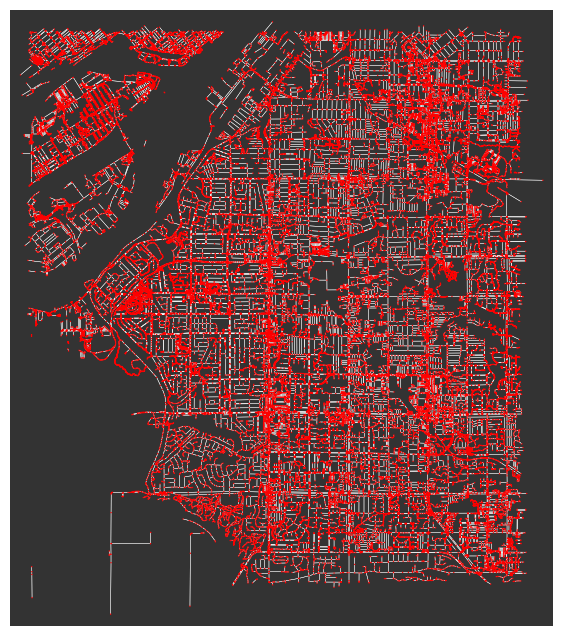

In [45]:
import pytrack.analytics
import pytrack.matching
import pytrack.matching.mpmatching
import pytrack.matching.mpmatching_utils
import logging

min_lat = None
max_lat = None
min_lng = None
max_lng = None

for df in routes.values():
    df = df/11930465
    if min_lat is None:
        min_lat = df['position_lat'].min()
        max_lat = df['position_lat'].max()
        min_lng = df['position_long'].min()
        max_lng = df['position_long'].max()
    
    if df['position_lat'].min() < min_lat:
        min_lat = df['position_lat'].min()
    if df['position_lat'].max() > max_lat:
        max_lat = df['position_lat'].max()
    if df['position_long'].min() < min_lng:
        min_lng = df['position_long'].min()
    if df['position_long'].max() > max_lng:
        max_lng = df['position_long'].max()

print(min_lat,min_lng,max_lat,max_lng)
H = ox.graph_from_bbox([max_lng,min_lat,min_lng,max_lat],network_type='walk',retain_all=True,truncate_by_edge=True,simplify=False)
C = nx.compose(G,H)


# plot the network, but do not show it or close it yet
fig, ax = ox.plot.plot_graph(
    C,
    show=False,
    close=False,
    bgcolor="#333333",
    edge_color="w",
    edge_linewidth=0.3,
    node_size=1,
    node_color='r'
)

# # to this matplotlib axis, add the place shape(s)
# gdf.plot(ax=ax, fc="k", ec="#666666", lw=1, alpha=1, zorder=-1)
# # optionally set up the axes extents
# margin = 0.02
# west, south, east, north = gdf.union_all().bounds
# margin_ns = (north - south) * margin
# margin_ew = (east - west) * margin
# ax.set_ylim((south - margin_ns, north + margin_ns))
# ax.set_xlim((west - margin_ew, east + margin_ew))
plt.show()


In [ ]:
# import re

# # df = pd.read_csv('routes.csv',index_col=['activity_id','timestamp'])
# # print(df.isnull().values.sum())

# with open('subgraph.txt') as file:
#     subgraph_str = file.read()

# subgraph_nodes = list(map(int,re.findall(r"[0-9]+",subgraph_str)))
# print(sorted(subgraph_nodes))

# subgraph = C.subgraph(subgraph_nodes).copy()
# print(len(C))
# print(len(subgraph))
# print(sorted(C.nodes()))

In [46]:
paths = []
j = 0
for id,df in routes.items():
    print(j,'id:',id)
    if j < 43:
        j = j+1
        continue
    df = df/11930465
    df = df[df['position_lat'].notnull()]
    latitude = df['position_lat'].to_list()
    longitude = df['position_long'].to_list()

    points = [(lat, lng) for lat, lng in zip(latitude, longitude)]
    # print((df['position_lat'].mean(),df['position_long'].mean()))
    loc = (df['position_lat'].mean(),df['position_long'].mean())
    print('drawing graph')
    maps = pytrack.analytics.visualization.Map(location=loc)
    maps.add_graph(C, plot_nodes=True)
    # maps

    print('finding candidates')
    # print(C.keys())
    C_interp, candidates = pytrack.matching.candidate.get_candidates(C, points, interp_dist=0,closest=True,radius=50)
    # maps.draw_candidates(candidates,30)
    # maps

    print('filling missing candidates')
    for idx, (lat, lng) in enumerate(points):
        if idx not in(candidates.keys()):
            nearest,dist = ox.nearest_nodes(C,lng,lat,return_dist=True)
            edges = C.edges(nearest,data=True)
            edge_nodes = [node for edge in edges for node in edge[:2]]
            candidates[idx] = {"observation": (lat,lng),
                        "osmid": [nearest],
                        "edge_osmid": [edge[2]['osmid'] for edge in edges],
                        "candidates": [tuple([np.float64(C.nodes[node]['y']),np.float64(C.nodes[node]['x'])]) for node in edge_nodes],
                        "candidate_type": np.full(len(edge_nodes),False),
                        "dists": [dist]
            }

    print('creating trellis')
    trellis = pytrack.matching.mpmatching_utils.create_trellis(candidates)
    # print('drawing trellis')
    # trellis_draw = pytrack.analytics.visualization.draw_trellis(trellis,figsize=(150,120))
    print('performing matching')
    try:
        path_prob, pred = pytrack.matching.mpmatching.viterbi_search(C_interp,trellis)
    except:
        break
    print('saving path')
    paths.append(pytrack.matching.mpmatching_utils.create_path(C_interp,trellis,pred))

    j=j+1
# print('displaying trellis')
# trellis_draw

#     print('drawing path')
#     maps.draw_path(C_interp,trellis,pred)

# print('displaying map')
# maps


0 id: 2440482282
1 id: 2448416540
2 id: 2458899554
3 id: 2458930593
4 id: 2467276527
5 id: 2467299565
6 id: 2475717320
7 id: 2481145303
8 id: 2483924803
9 id: 2499515100
10 id: 2507594515
11 id: 2510444064
12 id: 2513619095
13 id: 2515749669
14 id: 2517956281
15 id: 2524219131
16 id: 2530070948
17 id: 2535531765
18 id: 2538893098
19 id: 2552575331
20 id: 2563101945
21 id: 2576621923
22 id: 2582138434
23 id: 2605636425
24 id: 2637282973
25 id: 2642326750
26 id: 2645410572
27 id: 2652013783
28 id: 2657968295
29 id: 2675057506
30 id: 2683765267
31 id: 2689137075
32 id: 2695097101
33 id: 2703717346
34 id: 2709301089
35 id: 2712689820
36 id: 2723768862
37 id: 2745088391
38 id: 2747960616
39 id: 2753074297
40 id: 2766172471
41 id: 2771301065
42 id: 2784180502
43 id: 2789147370
drawing graph
finding candidates
A total of 282 points has no candidates: (32, 33, 34, 87, 88, 106, 107, 111, 112, 124, 129, 130, 132, 133, 134, 142, 143, 144, 145, 146, 147, 148, 149, 150, 157, 158, 159, 160, 161, 162

In [ ]:
# print([len(c) for c in sorted(nx.weakly_connected_components(trellis))])

In [48]:
test = candidates.copy()
connect = trellis.copy()
last = max(int(u_name.split('_')[0]) for u_name in connect.nodes() if u_name not in ('start','target'))

In [ ]:
# print(len([c for c in sorted(nx.weakly_connected_components(C))]))
# print(len([c for c in sorted(nx.strongly_connected_components(C))]))

# def unconnected_nodes(trellis):
#     components = {}
#     to_remove = []
#     for u_name in trellis.nodes:
#         if u_name == 'start':
#             continue
#         u = trellis.nodes[u_name]['candidate']
#         if u.node_id not in components.keys():
#             for c in nx.weakly_connected_components(C):
#                 if u.node_id in c:
#                     components[u.node_id] = c
#                     break
#         for v_name in trellis.successors(u_name):
#             v = trellis.nodes[v_name]['candidate']
#             if v.node_id not in components[u.node_id]:
#                 to_remove.append((u_name,v_name))
#             else:
#                 components[v.node_id] = c
#     for u,v in to_remove:
#         trellis.remove_edge(u,v)
#     return(trellis)


In [63]:
print(len([c for c in sorted(nx.connected_components(trellis.to_undirected()))]))
print(len([c for c in sorted(nx.connected_components(connect.to_undirected()))]))

def disconnect_nodes(trellis,components={}):
    to_remove = []
    for u_name in trellis.nodes:
        if u_name == 'start':
            continue
        u = trellis.nodes[u_name]['candidate']
        if u.node_id not in components.keys():
            for c in nx.strongly_connected_components(C):
                if u.node_id in c:
                    components[u.node_id] = c
                    break
        for v_name in trellis.successors(u_name):
            v = trellis.nodes[v_name]['candidate']
            if v.node_id not in components[u.node_id]:
                to_remove.append((u_name,v_name))
            else:
                components[v.node_id] = c
    for u,v in to_remove:
        trellis.remove_edge(u,v)
    return(trellis)

def sort_components(component):
    if 'start' in component:
        return 0
    elif 'target' in component:
        return float('inf')
    else:
        return min({int(node.split('_')[0]) for node in component})

def reconnect_nodes(trellis):
    print('hi')
    components = sorted(nx.weakly_connected_components(trellis), key=sort_components)
    for i in range(0,len(components),2):
        out_nodes = [node for (node, deg) in trellis.out_degree(components[i]) if deg == 0]
        in_nodes = [node for (node, deg) in trellis.in_degree(components[i+1]) if deg == 0]
        print(out_nodes,in_nodes)
    # print(out_nodes,in_nodes)

# disconnect_nodes(connect)
reconnect_nodes(connect)

1
75
hi
['226_2', '226_3'] ['32_0']
['34_0'] ['87_0']
['218_0'] ['226_0']
['226_1'] ['227_0']
['227_1'] ['232_3', '228_1', '234_6', '232_4', '228_0', '234_5', '236_4', '228_2', '232_1', '232_2', '229_4', '232_0', '229_5']
['237_0'] ['237_1']
['237_2'] ['246_2', '246_3', '247_3', '247_5', '237_3', '249_2', '251_5', '243_7', '243_6', '247_4', '245_5', '246_0', '246_1', '250_4', '237_4', '246_4', '247_6', '251_2', '247_0', '247_2', '241_5', '247_1', '245_4', '251_1', '253_0']
['254_0'] ['255_0']
['256_0'] ['257_0']
['258_0'] ['259_0']
['323_0'] ['279_0']
['280_0'] ['281_0']
['282_0'] ['283_0']
['284_0'] ['285_0']
['286_0'] ['287_0']
['288_0'] ['289_0']
['379_0'] ['331_0']
['605_0'] ['471_14', '471_3', '471_10', '493_5', '470_9', '486_8', '482_9', '492_11', '473_13', '473_14', '492_5', '481_0', '482_11', '494_13', '493_11', '494_6', '477_6', '475_11', '472_15', '482_10', '492_9', '490_0', '493_9', '481_6', '471_11', '470_12', '481_1', '482_1', '482_6', '488_5', '488_9', '490_1', '477_0', '

IndexError: list index out of range

In [ ]:
# print(len([c for c in sorted(nx.connected_components(trellis.to_undirected()))]))
# print(len([c for c in sorted(nx.connected_components(connect.to_undirected()))]))
# print(list(nx.isolates(trellis)))
# print(list(nx.isolates(connect)))

In [ ]:
# def reconnect_trellis(trellis,last_lvl,increase):
#     nodes = list(trellis)
#     for u_name in trellis.nodes():
#         if trellis.out_degree(u_name) == 0 and '_' in u_name:
#             level = int(u_name.split('_')[0])
#             if level == last_lvl-increase +1:
#                 print(level)
#                 print(last)
#                 trellis.add_edge(u_name,'target')
#             elif level > last_lvl-increase +1:
#                 break
#             else:
#                 for i in range(increase,last_lvl-increase+1):
#                 trellis.add_edges_from([(u_name,v_name) for v_name in [node for node in nodes if str(level+increase) in node]])
#     return trellis

# print(len([c for c in sorted(nx.connected_components(connect.to_undirected()))]))
# print(list(nx.isolates(connect)))

In [ ]:
# print(len([c for c in sorted(nx.connected_components(connect.to_undirected()))]))
# print(list(nx.isolates(connect)))

# connect = unconnected_nodes(connect)

# print(len([c for c in sorted(nx.connected_components(connect.to_undirected()))]))
# print(list(nx.isolates(connect)))

# connect = reconnect_trellis(connect,last,9)

# print(len([c for c in sorted(nx.connected_components(connect.to_undirected()))]))
# print(list(nx.isolates(connect)))

In [ ]:
# print(C.edges(1004396723,data=True))
# print(C.nodes[1004396728])
# print(C.nodes[1004396718])

# for pt in test.values():
#     if np.any(pt['candidate_type']):
#         print(True)

# print(test[0])
# print()

# for idx, (lat, lng) in enumerate(points):
#     if idx%50 == 0:
#         print(idx)
#     if idx not in(test.keys()):
#         nearest,dist = ox.nearest_nodes(C,lng,lat,return_dist=True)
#         edges = C.edges(nearest,data=True)
#         edge_nodes = [node for edge in edges for node in edge[:2]]
#         test[idx] = {"observation": (lat,lng),
#                      "osmid": [nearest],
#                      "edge_osmid": [edge[2]['osmid'] for edge in edges],
#                      "candidates": [tuple([np.float64(C.nodes[node]['y']),np.float64(C.nodes[node]['x'])]) for node in edge_nodes],
#                      "candidate_type": np.full(len(edge_nodes),False),
#                      "dists": [dist]
#         }
#         # print(test[idx])
#         # print(idx,
#         #       (lat,lng),
#         #       [ox.nearest_nodes(C, lng,lat)], [edge[2]['osmid'] for edge in C.edges(ox.nearest_nodes(C,lng,lat),data=True)],
#         #       [tuple([np.float64(C.nodes[node]['y']),np.float64(C.nodes[node]['x'])]) for edge in C.edges(ox.nearest_nodes(C,lng,lat),data=True) for node in edge[:2]],
#         #       np.full(len([node for edge in C.edges(ox.nearest_nodes(C,lng,lat),data=True) for node in edge[:2]]),False),
#         #       [ox.nearest_nodes(C, lng,lat,return_dist=True)[1]])
# print(len(test))

In [ ]:
# nodes1,coords1 = pytrack.matching.mpmatching_utils.create_matched_path(C_interp,trellis,pred)
# path2 = pytrack.matching.mpmatching_utils.create_path(C_interp,trellis,pred)

In [ ]:
# import pytrack.analytics
# import pytrack.matching
# print(len())
# print(df.isnull().values.sum())


# C_interp, candidates = pytrack.matching.candidate.get_candidates(C, points, interp_dist=5,closest=True,radius=30)
# maps.draw_candidates(candidates,30)
# maps